# Generation for NLP Baseline Code

```
python3.10 -m venv --system-site-packages /data/ephemeral/home/py310
source /data/ephemeral/home/py310/bin/activate
pip install --upgrade pip
```
위에 커맨드를 사용하여 가상환경을 만들고 IDE의 커널을 생성한 가상환경으로 변경해주세요.

## Install Packages

In [ ]:
# !pip install --no-cache-dir torch==2.9.1+cu128 --index-url https://download.pytorch.org/whl/cu128
# !pip install --no-cache-dir -r requirements.txt

## Import Necessary Libraries

In [25]:
import torch
import transformers
from ast import literal_eval
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM, SFTConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import Dataset
import json
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import evaluate
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from peft import AutoPeftModelForCausalLM, LoraConfig

pd.set_option('display.max_columns', 1000)

In [26]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(42) # magic number :)

## EDA

### Load Data

In [28]:
# Load the train dataset
# TODO Train Data 경로 입력
dataset = pd.read_csv('/data/ephemeral/pro-nlp-generationfornlp-nlp-13/data/train.csv') 

# Flatten the JSON dataset
records = []
for _, row in dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
df = pd.DataFrame(records)

### Print missing values

In [4]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
id                  0
paragraph           0
question            0
choices             0
answer              0
question_plus    2031
dtype: int64


### Basic information about the dataset

In [5]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2031 non-null   object
 1   paragraph      2031 non-null   object
 2   question       2031 non-null   object
 3   choices        2031 non-null   object
 4   answer         2031 non-null   int64 
 5   question_plus  0 non-null      object
dtypes: int64(1), object(5)
memory usage: 95.3+ KB


### EDA on 'question' and 'choices'

In [33]:
# Combine 'question' and 'question_plus' if available
df['question_plus'] = df['question_plus'].fillna('')
df['full_question'] = df.apply(lambda x: x['question'] + ' ' + x['question_plus'] if x['question_plus'] else x['question'], axis=1)

# Calculate the length of each question
df['question_length'] = df['full_question'].apply(len)
df['paragraph_length'] = df['paragraph'].apply(len)
df['num_choices'] = df['choices'].apply(len)

In [34]:
df4 = df[df['num_choices'] == 4]
df5 = df[df['num_choices'] == 5]

### Question Length Distribution

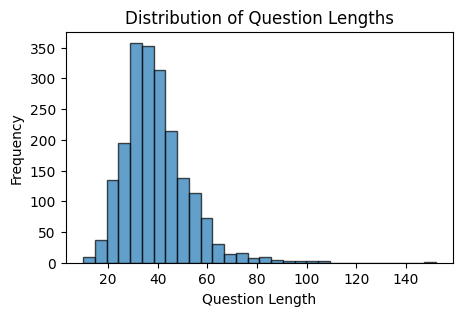

In [30]:
plt.figure(figsize=(5, 3))
plt.hist(df['question_length'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

### Paragraph Length Distribution

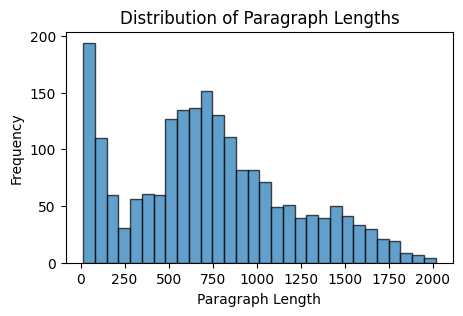

In [8]:
plt.figure(figsize=(5, 3))
plt.hist(df['paragraph_length'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Paragraph Lengths')
plt.xlabel('Paragraph Length')
plt.ylabel('Frequency')
plt.show()

# 질문 길이와 본문 길이 상관성 분석

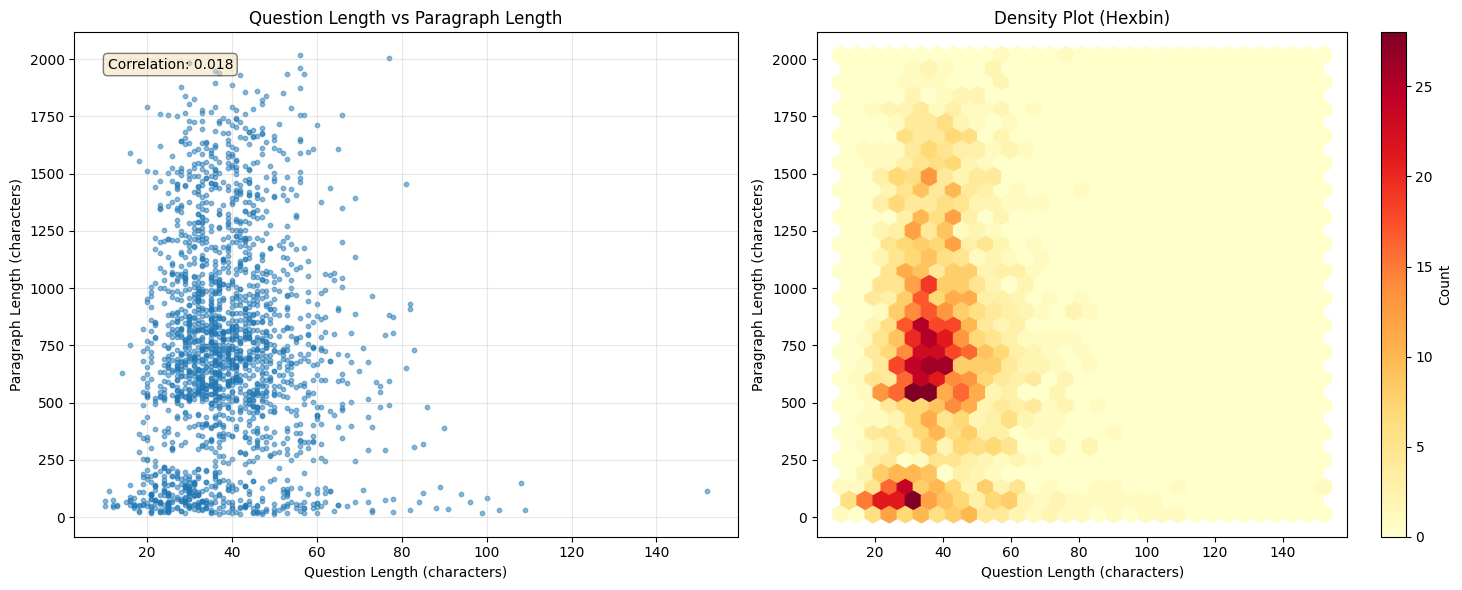

In [9]:
def plot_scatter_comparison(df):
    """질문 길이 vs paragraph 길이 산점도"""
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 기본 산점도
    axes[0].scatter(df['question_length'], df['paragraph_length'], 
                   alpha=0.5, s=10)
    axes[0].set_xlabel('Question Length (characters)')
    axes[0].set_ylabel('Paragraph Length (characters)')
    axes[0].set_title('Question Length vs Paragraph Length')
    axes[0].grid(alpha=0.3)
    
    # 상관관계 표시
    correlation = df['question_length'].corr(df['paragraph_length'])
    axes[0].text(0.05, 0.95, f'Correlation: {correlation:.3f}',
                transform=axes[0].transAxes, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 밀도 산점도 (hexbin)
    axes[1].hexbin(df['question_length'], df['paragraph_length'], 
                   gridsize=30, cmap='YlOrRd')
    axes[1].set_xlabel('Question Length (characters)')
    axes[1].set_ylabel('Paragraph Length (characters)')
    axes[1].set_title('Density Plot (Hexbin)')
    plt.colorbar(axes[1].collections[0], ax=axes[1], label='Count')
    
    plt.tight_layout()
    plt.savefig('scatter_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_scatter_comparison(df)

## 심층 EDA Frequency of Words in Question

In [10]:
# !pip install konlpy
# !pip install wordcloud 

In [11]:
from konlpy.tag import Okt
from collections import Counter

def Q_korean_word_freq(df):
    okt = Okt()
    stopwords = {
        '것', '수', '등', '및', '제', '때', '대한',
        '옳은', '않은', '틀린', '설명', '인가', '무엇',
        '다음', '보기', '문제', '답', '번', '있는' ,'가장',
    }
    # 모든 질문 합치기
    all_text = ' '.join(df['question'].astype(str))
    
    # 형태소 분석 (명사만 추출)
    nouns = okt.nouns(all_text)
    
    # 한 글자 단어 제거
    nouns = [word for word in nouns if len(word) > 1 and word not in stopwords]
    
    # 빈도수 계산
    word_freq = Counter(nouns)
    
    # 상위 30개
    print("=== 상위 30개 명사 ===")
    for word, count in word_freq.most_common(30):
        print(f"{word}: {count}번")
    
    return word_freq

Q_freq = Q_korean_word_freq(df)

=== 상위 30개 명사 ===
이유: 225번
얼마: 140번
이름: 121번
주요: 95번
어디: 80번
아파트: 77번
구절: 73번
정부: 71번
언제: 70번
내용: 58번
누구: 58번
주장: 57번
언급: 57번
미국: 57번
사건: 56번
목적: 53번
가능성: 50번
중국: 50번
경제: 49번
최근: 48번
한국: 47번
위해: 43번
시장: 43번
서울: 43번
기업: 42번
사업: 42번
원인: 41번
올해: 41번
관련: 40번
영향: 39번


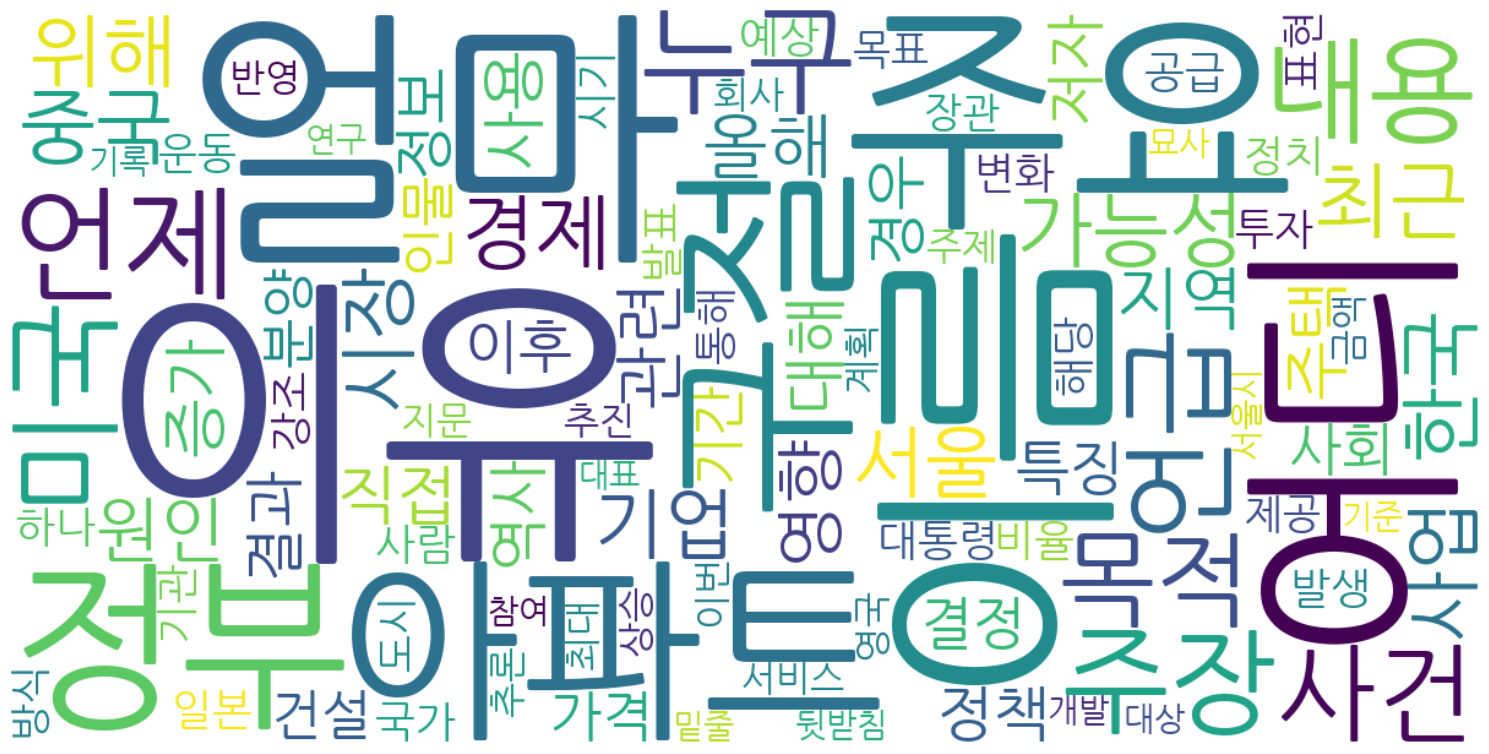

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud_from_freq(word_freq, title='단어 빈도 워드클라우드'):
    """Counter 객체로 워드클라우드 생성"""
    
    # 한글 폰트 설정 (환경에 맞게 선택)
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # Linux
    # font_path = 'C:/Windows/Fonts/malgun.ttf'  # Windows
    # font_path = '/System/Library/Fonts/AppleGothic.ttf'  # Mac
    
    # 워드클라우드 생성
    wordcloud = WordCloud(
        font_path=font_path,
        width=1200,
        height=600,
        background_color='white',
        max_words=100,
        relative_scaling=0.3,
        colormap='viridis'
    ).generate_from_frequencies(word_freq)  # ← Counter 객체 직접 사용!
    
    # 시각화
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# 사용
create_wordcloud_from_freq(Q_freq)

## 심층 EDA Frequency of Words in Paragraph

In [13]:
from konlpy.tag import Okt
from collections import Counter

def P_korean_word_freq(df):
    okt = Okt()
    stopwords = {
        '것', '수', '등', '및', '제', '때', '대한',
        '옳은', '않은', '틀린', '설명', '인가', '무엇',
        '다음', '보기', '문제', '답', '번', '있는' ,'가장',
    }
    # 모든 질문 합치기
    all_text = ' '.join(df['paragraph'].astype(str))
    
    # 형태소 분석 (명사만 추출)
    nouns = okt.nouns(all_text)
    
    # 한 글자 단어 제거
    nouns = [word for word in nouns if len(word) > 1 and word not in stopwords]
    
    # 빈도수 계산
    word_freq = Counter(nouns)
    
    # 상위 30개
    print("=== 상위 30개 명사 ===")
    for word, count in word_freq.most_common(30):
        print(f"{word}: {count}번")
    
    return word_freq

P_freq = P_korean_word_freq(df)

=== 상위 30개 명사 ===
우리: 969번
기업: 953번
정부: 951번
사업: 867번
미국: 820번
위해: 814번
중국: 785번
한국: 779번
시장: 768번
통해: 740번
서울: 740번
지역: 722번
분양: 699번
주택: 679번
지난: 667번
아파트: 666번
사람: 664번
가구: 647번
때문: 633번
지난해: 604번
개발: 566번
계획: 565번
건설: 561번
이번: 555번
올해: 533번
투자: 532번
모든: 514번
이상: 512번
대해: 506번
경우: 499번


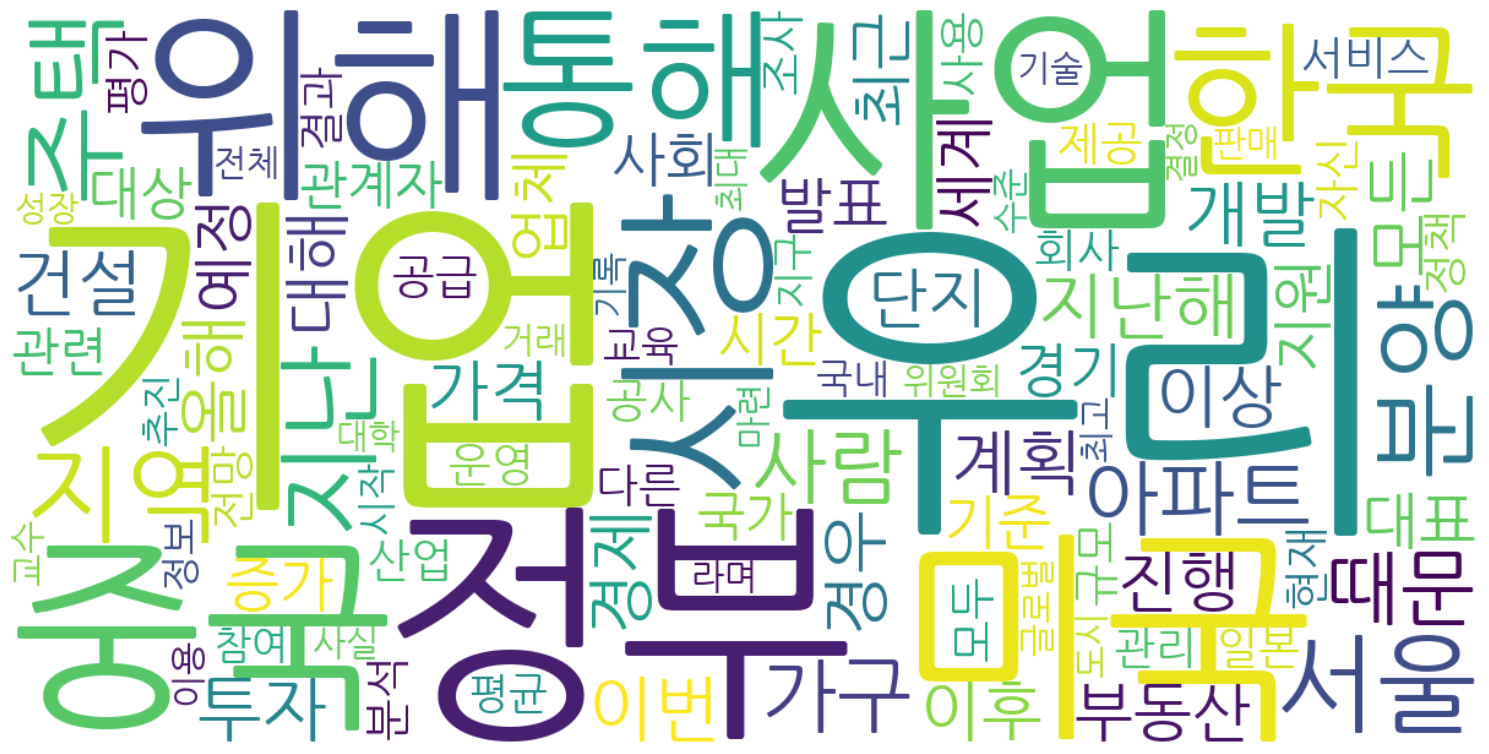

In [14]:
create_wordcloud_from_freq(P_freq)

In [23]:
df[df['question']=='베트남 전쟁 중 정치적 불화는 다음 중 어떤 전쟁의 정치적 불화와 가장 유사한가요?'].paragraph

587    이 지문에 나타난 정보는 무엇입니까? 우리 지도자들은 북으로부터의 침략을 막는 이야...
Name: paragraph, dtype: object

In [24]:
df[df['question']=='이 구절에서 에라스무스의 인본주의 유형과 가장 유사한 남부 르네상스 운동은?'].paragraph

118    "1500년 에라스무스가 도버에서 불행을 겪고 집필하여 마운트조이에게 헌정한 작품인...
Name: paragraph, dtype: object

=== Question Length Distribution ===
4-choices:
count    792.000000
mean      40.287879
std       16.495272
min       10.000000
25%       28.000000
50%       38.000000
75%       49.000000
max      152.000000
Name: question_length, dtype: float64

5-choices:
count    1239.000000
mean       38.573043
std        10.053939
min        16.000000
25%        31.500000
50%        37.000000
75%        44.000000
max        82.000000
Name: question_length, dtype: float64


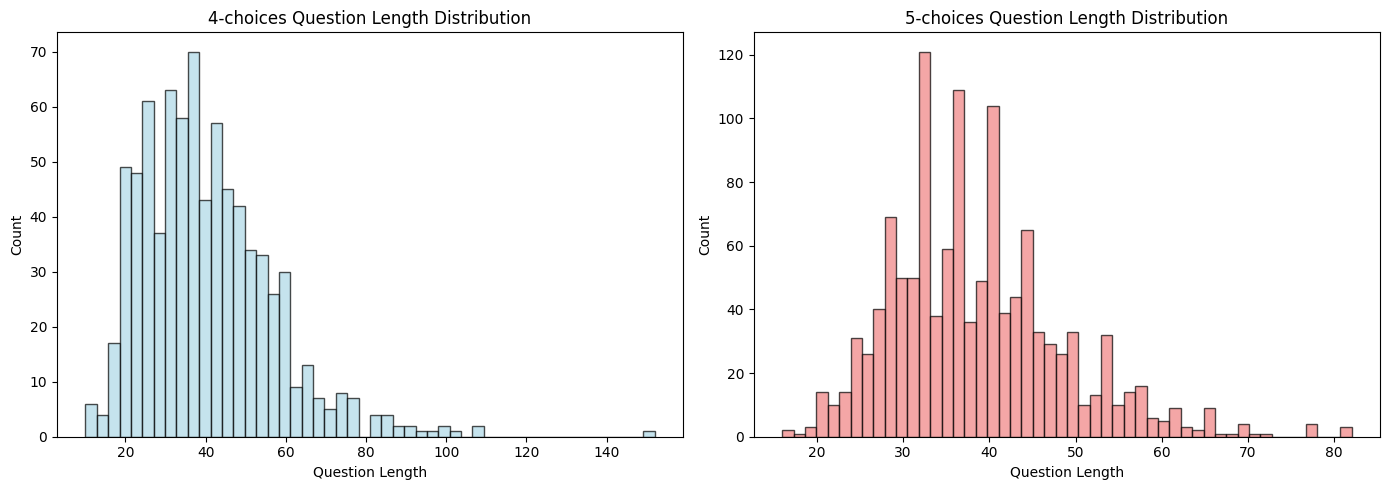


=== 4-choices Question Length GMM ===
n=1: BIC=6700.0
n=2: BIC=6610.1
n=3: BIC=6590.4
n=4: BIC=6603.7
n=5: BIC=6618.3

Optimal n_components for 4-choices: 3

=== 5-choices Question Length GMM ===
n=1: BIC=9248.5
n=2: BIC=9146.4
n=3: BIC=9158.9
n=4: BIC=9184.2
n=5: BIC=9192.8

Optimal n_components for 5-choices: 2

=== 4-choices Question Length Clusters ===
Cluster 0: mean=33.6, std=9.5, count=617
Cluster 1: mean=63.9, std=13.9, count=175

=== 5-choices Question Length Clusters ===
Cluster 0: mean=34.2, std=6.0, count=946
Cluster 1: mean=52.6, std=7.4, count=293

=== Final Label Distribution ===
4-choices:
final_label
4choices_qlen_cluster0    617
4choices_qlen_cluster1    175
Name: count, dtype: int64

5-choices:
final_label
5choices_qlen_cluster0    946
5choices_qlen_cluster1    293
Name: count, dtype: int64


/tmp/ipykernel_2096904/3413934187.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['q_length_cluster'] = gmm_4.fit_predict(data_4_qlen)
/tmp/ipykernel_2096904/3413934187.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['q_length_cluster'] = gmm_5.fit_predict(data_5_qlen)
/tmp/ipykernel_2096904/3413934187.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 먼저 question_length 분포 확인
print("=== Question Length Distribution ===")
print("4-choices:")
print(df4['question_length'].describe())
print("\n5-choices:")
print(df5['question_length'].describe())

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df4['question_length'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[0].set_title('4-choices Question Length Distribution')
axes[0].set_xlabel('Question Length')
axes[0].set_ylabel('Count')

axes[1].hist(df5['question_length'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_title('5-choices Question Length Distribution')
axes[1].set_xlabel('Question Length')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# 4지선다에 대해 GMM으로 question_length 기준 세분화
print("\n=== 4-choices Question Length GMM ===")
data_4_qlen = df4['question_length'].values.reshape(-1, 1)

bic_scores_4 = []
for n in range(1, 6):
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(data_4_qlen)
    bic_scores_4.append(gmm.bic(data_4_qlen))
    print(f"n={n}: BIC={gmm.bic(data_4_qlen):.1f}")

optimal_n_4 = np.argmin(bic_scores_4) + 1
print(f"\nOptimal n_components for 4-choices: {optimal_n_4}")

# 5지선다에 대해 GMM으로 question_length 기준 세분화
print("\n=== 5-choices Question Length GMM ===")
data_5_qlen = df5['question_length'].values.reshape(-1, 1)

bic_scores_5 = []
for n in range(1, 6):
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(data_5_qlen)
    bic_scores_5.append(gmm.bic(data_5_qlen))
    print(f"n={n}: BIC={gmm.bic(data_5_qlen):.1f}")

optimal_n_5 = np.argmin(bic_scores_5) + 1
print(f"\nOptimal n_components for 5-choices: {optimal_n_5}")

# 각각 최적 개수로 클러스터링 (일단 2개로)
gmm_4 = GaussianMixture(n_components=3, random_state=42)
df4['q_length_cluster'] = gmm_4.fit_predict(data_4_qlen)

gmm_5 = GaussianMixture(n_components=2, random_state=42)
df5['q_length_cluster'] = gmm_5.fit_predict(data_5_qlen)

# 클러스터 통계
print("\n=== 4-choices Question Length Clusters ===")
for cluster in sorted(df4['q_length_cluster'].unique()):
    subset = df4[df4['q_length_cluster'] == cluster]
    print(f"Cluster {cluster}: mean={subset['question_length'].mean():.1f}, "
          f"std={subset['question_length'].std():.1f}, count={len(subset)}")

print("\n=== 5-choices Question Length Clusters ===")
for cluster in sorted(df5['q_length_cluster'].unique()):
    subset = df5[df5['q_length_cluster'] == cluster]
    print(f"Cluster {cluster}: mean={subset['question_length'].mean():.1f}, "
          f"std={subset['question_length'].std():.1f}, count={len(subset)}")

# 최종 라벨 생성: "num_choices_q_length_cluster"
df4['final_label'] = df4.apply(
    lambda x: f"4choices_qlen_cluster{x['q_length_cluster']}", axis=1)

df5['final_label'] = df5.apply(
    lambda x: f"5choices_qlen_cluster{x['q_length_cluster']}", axis=1)

print("\n=== Final Label Distribution ===")
print("4-choices:")
print(df4['final_label'].value_counts())
print("\n5-choices:")
print(df5['final_label'].value_counts())

=== Finding optimal n_components ===
4-choices n=1: BIC=6700.0
4-choices n=2: BIC=6610.1
4-choices n=3: BIC=6590.4
4-choices n=4: BIC=6603.7
4-choices n=5: BIC=6618.3

Optimal n_components for 4-choices: 3
5-choices n=1: BIC=9248.5
5-choices n=2: BIC=9146.4
5-choices n=3: BIC=9158.9
5-choices n=4: BIC=9184.2
5-choices n=5: BIC=9192.8

Optimal n_components for 5-choices: 2

=== 4-choices Question Length Clusters ===
short: mean=28.6, std=6.7, count=430, ratio=54.3%
medium: mean=50.1, std=7.1, count=317, ratio=40.0%
long: mean=82.6, std=15.2, count=45, ratio=5.7%

=== 5-choices Question Length Clusters ===
short: mean=34.2, std=6.0, count=946, ratio=76.4%
long: mean=52.6, std=7.4, count=293, ratio=23.6%


/tmp/ipykernel_2096904/681843286.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['q_length_cluster'] = gmm_4.fit_predict(data_4_qlen)
/tmp/ipykernel_2096904/681843286.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['q_length_cluster'] = gmm_5.fit_predict(data_5_qlen)
/tmp/ipykernel_2096904/681843286.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

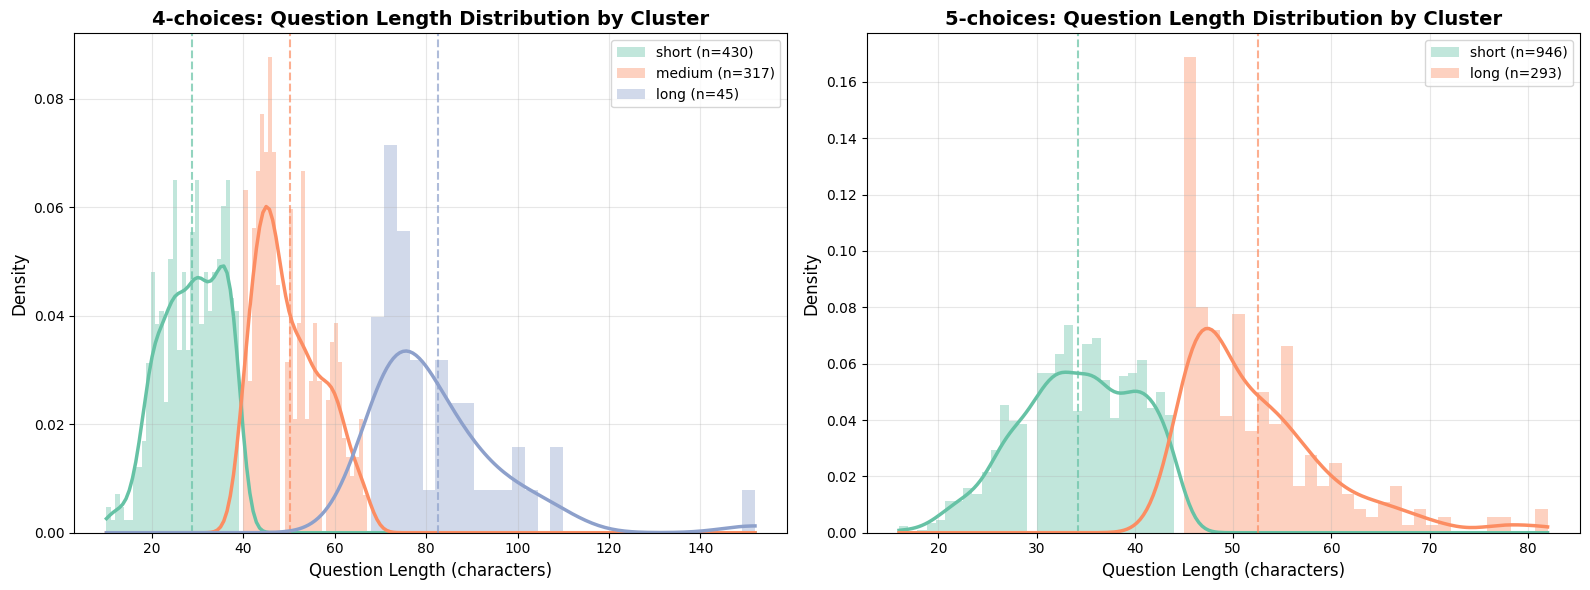

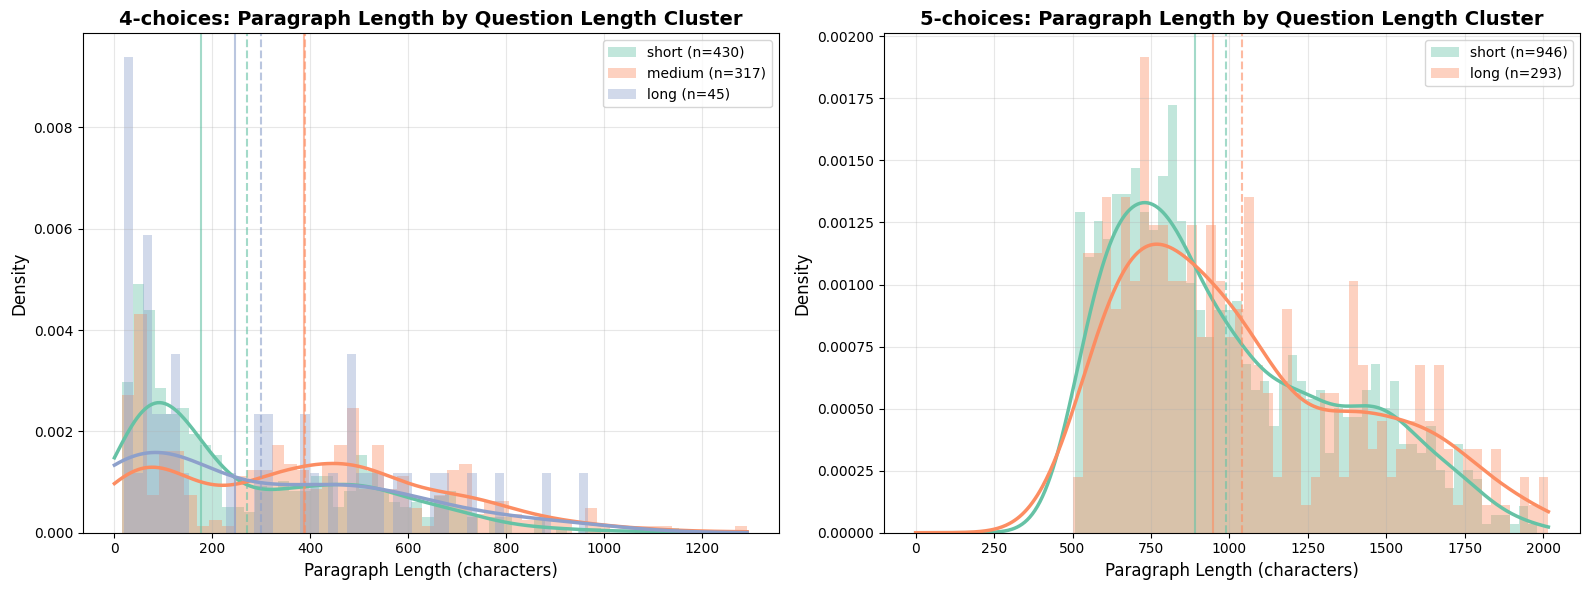

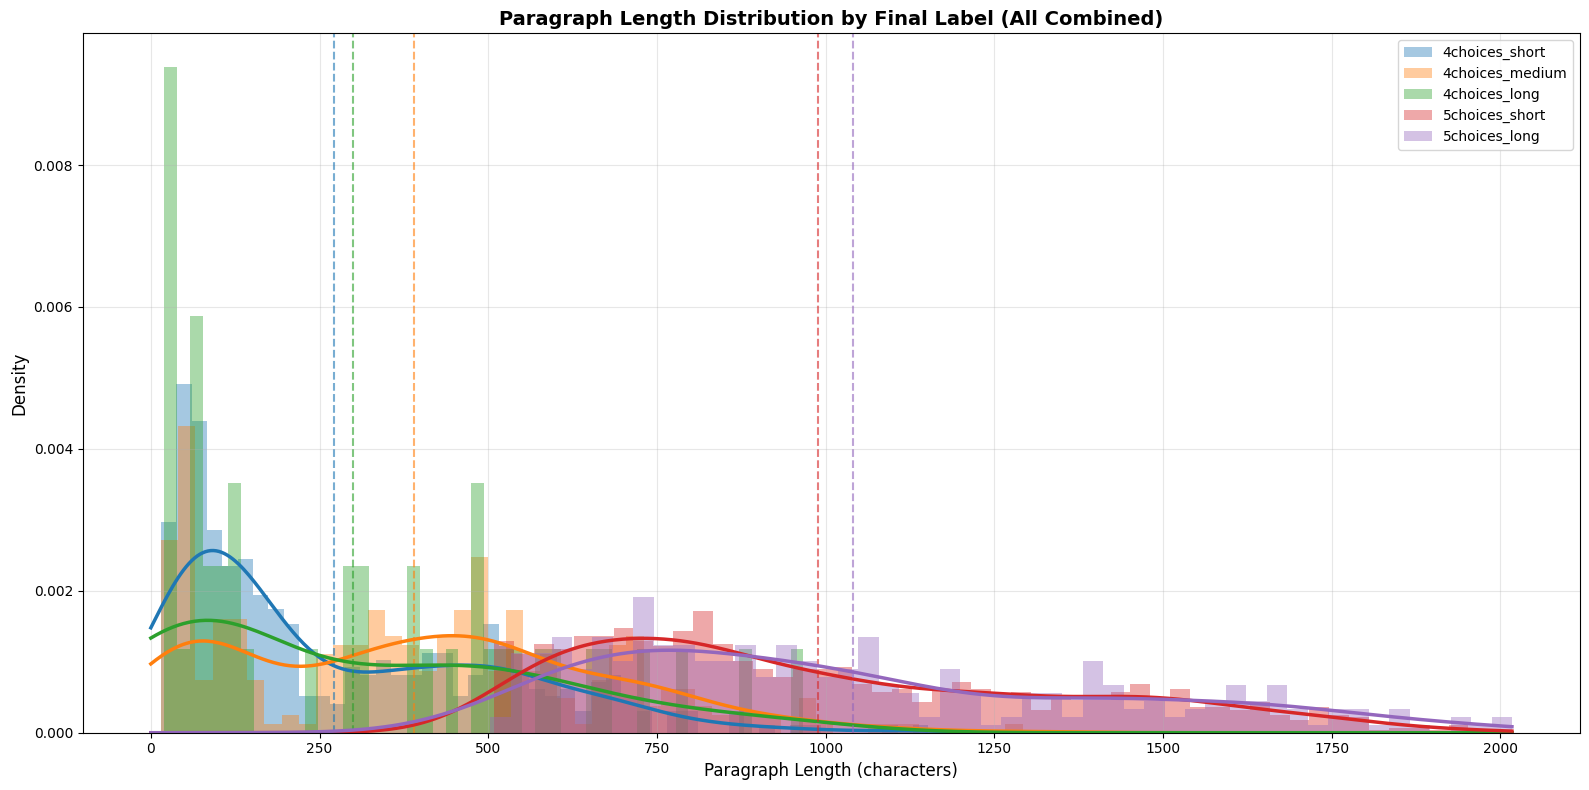


=== Final Label Statistics ===

Label Counts:
final_label
4choices_long       45
4choices_medium    317
4choices_short     430
5choices_long      293
5choices_short     946
Name: count, dtype: int64

=== Detailed Statistics by Final Label ===

4choices_long:
  Count: 45 (2.2%)
  Paragraph Length - Mean: 299.1, Median: 246.0, Std: 267.8
  Question Length - Mean: 82.6, Median: 77.0, Std: 15.2

4choices_medium:
  Count: 317 (15.6%)
  Paragraph Length - Mean: 389.3, Median: 387.0, Std: 269.0
  Question Length - Mean: 50.1, Median: 48.0, Std: 7.1

4choices_short:
  Count: 430 (21.2%)
  Paragraph Length - Mean: 271.1, Median: 177.0, Std: 233.0
  Question Length - Mean: 28.6, Median: 29.0, Std: 6.7

5choices_long:
  Count: 293 (14.4%)
  Paragraph Length - Mean: 1040.0, Median: 947.0, Std: 377.2
  Question Length - Mean: 52.6, Median: 50.0, Std: 7.4

5choices_short:
  Count: 946 (46.6%)
  Paragraph Length - Mean: 988.7, Median: 891.5, Std: 351.0
  Question Length - Mean: 34.2, Median: 35.0, S

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import gaussian_kde

# 1. 데이터 준비 (df4: 4지선다, df5: 5지선다가 이미 있다고 가정)

# 2. Question Length로 GMM 클러스터링

# 2-1. 최적 컴포넌트 개수 찾기
print("=== Finding optimal n_components ===")

# 4-choices
data_4_qlen = df4['question_length'].values.reshape(-1, 1)
bic_scores_4 = []
for n in range(1, 6):
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(data_4_qlen)
    bic_scores_4.append(gmm.bic(data_4_qlen))
    print(f"4-choices n={n}: BIC={gmm.bic(data_4_qlen):.1f}")

optimal_n_4 = np.argmin(bic_scores_4) + 1
print(f"\nOptimal n_components for 4-choices: {optimal_n_4}")

# 5-choices
data_5_qlen = df5['question_length'].values.reshape(-1, 1)
bic_scores_5 = []
for n in range(1, 6):
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(data_5_qlen)
    bic_scores_5.append(gmm.bic(data_5_qlen))
    print(f"5-choices n={n}: BIC={gmm.bic(data_5_qlen):.1f}")

optimal_n_5 = np.argmin(bic_scores_5) + 1
print(f"\nOptimal n_components for 5-choices: {optimal_n_5}")

# 2-2. 최적 개수로 클러스터링
gmm_4 = GaussianMixture(n_components=optimal_n_4, random_state=42)
df4['q_length_cluster'] = gmm_4.fit_predict(data_4_qlen)

gmm_5 = GaussianMixture(n_components=optimal_n_5, random_state=42)
df5['q_length_cluster'] = gmm_5.fit_predict(data_5_qlen)

# 2-3. 클러스터를 평균 기준으로 정렬 (0=짧음, 1=중간, 2=긴)
cluster_means_4 = df4.groupby('q_length_cluster')['question_length'].mean().sort_values()
cluster_mapping_4 = {old: new for new, old in enumerate(cluster_means_4.index)}
df4['q_length_cluster'] = df4['q_length_cluster'].map(cluster_mapping_4)

cluster_means_5 = df5.groupby('q_length_cluster')['question_length'].mean().sort_values()
cluster_mapping_5 = {old: new for new, old in enumerate(cluster_means_5.index)}
df5['q_length_cluster'] = df5['q_length_cluster'].map(cluster_mapping_5)

# 2-4. 라벨 이름 매핑
if optimal_n_4 == 3:
    label_names_4 = {0: 'short', 1: 'medium', 2: 'long'}
elif optimal_n_4 == 2:
    label_names_4 = {0: 'short', 1: 'long'}
else:
    label_names_4 = {i: f'cluster{i}' for i in range(optimal_n_4)}

if optimal_n_5 == 2:
    label_names_5 = {0: 'short', 1: 'long'}
elif optimal_n_5 == 3:
    label_names_5 = {0: 'short', 1: 'medium', 2: 'long'}
else:
    label_names_5 = {i: f'cluster{i}' for i in range(optimal_n_5)}

df4['q_length_label'] = df4['q_length_cluster'].map(label_names_4)
df5['q_length_label'] = df5['q_length_cluster'].map(label_names_5)

# 2-5. 최종 라벨 생성
df4['final_label'] = '4choices_' + df4['q_length_label']
df5['final_label'] = '5choices_' + df5['q_length_label']

# 3. 클러스터 통계 출력
print("\n=== 4-choices Question Length Clusters ===")
for cluster in sorted(df4['q_length_cluster'].unique()):
    subset = df4[df4['q_length_cluster'] == cluster]
    print(f"{label_names_4[cluster]}: mean={subset['question_length'].mean():.1f}, "
          f"std={subset['question_length'].std():.1f}, count={len(subset)}, "
          f"ratio={len(subset)/len(df4)*100:.1f}%")

print("\n=== 5-choices Question Length Clusters ===")
for cluster in sorted(df5['q_length_cluster'].unique()):
    subset = df5[df5['q_length_cluster'] == cluster]
    print(f"{label_names_5[cluster]}: mean={subset['question_length'].mean():.1f}, "
          f"std={subset['question_length'].std():.1f}, count={len(subset)}, "
          f"ratio={len(subset)/len(df5)*100:.1f}%")

# 4. 시각화

# 4-1. Question Length Distribution (histogram + KDE)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 4-choices
colors_4 = plt.cm.Set2(range(optimal_n_4))
for i, cluster in enumerate(sorted(df4['q_length_cluster'].unique())):
    subset = df4[df4['q_length_cluster'] == cluster]
    
    # Histogram
    axes[0].hist(subset['question_length'], bins=30, alpha=0.4, 
                 color=colors_4[i], density=True,
                 label=f"{label_names_4[cluster]} (n={len(subset)})")
    
    # KDE line
    kde = gaussian_kde(subset['question_length'])
    x_range = np.linspace(df4['question_length'].min(), df4['question_length'].max(), 200)
    axes[0].plot(x_range, kde(x_range), color=colors_4[i], linewidth=2.5)
    
    # Mean line
    mean_val = subset['question_length'].mean()
    axes[0].axvline(mean_val, color=colors_4[i], linestyle='--', alpha=0.7, linewidth=1.5)

axes[0].set_xlabel('Question Length (characters)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('4-choices: Question Length Distribution by Cluster', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# 5-choices
colors_5 = plt.cm.Set2(range(optimal_n_5))
for i, cluster in enumerate(sorted(df5['q_length_cluster'].unique())):
    subset = df5[df5['q_length_cluster'] == cluster]
    
    # Histogram
    axes[1].hist(subset['question_length'], bins=30, alpha=0.4, 
                 color=colors_5[i], density=True,
                 label=f"{label_names_5[cluster]} (n={len(subset)})")
    
    # KDE line
    kde = gaussian_kde(subset['question_length'])
    x_range = np.linspace(df5['question_length'].min(), df5['question_length'].max(), 200)
    axes[1].plot(x_range, kde(x_range), color=colors_5[i], linewidth=2.5)
    
    # Mean line
    mean_val = subset['question_length'].mean()
    axes[1].axvline(mean_val, color=colors_5[i], linestyle='--', alpha=0.7, linewidth=1.5)

axes[1].set_xlabel('Question Length (characters)', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('5-choices: Question Length Distribution by Cluster', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('question_length_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

# 4-2. Paragraph Length Distribution by Final Label (histogram + KDE)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 4-choices
for i, cluster in enumerate(sorted(df4['q_length_cluster'].unique())):
    subset = df4[df4['q_length_cluster'] == cluster]
    
    # Histogram
    axes[0].hist(subset['paragraph_length'], bins=50, alpha=0.4, 
                 color=colors_4[i], density=True,
                 label=f"{label_names_4[cluster]} (n={len(subset)})")
    
    # KDE line
    kde = gaussian_kde(subset['paragraph_length'])
    x_range = np.linspace(0, df4['paragraph_length'].max(), 500)
    axes[0].plot(x_range, kde(x_range), color=colors_4[i], linewidth=2.5)
    
    # Mean and Median lines
    mean_val = subset['paragraph_length'].mean()
    median_val = subset['paragraph_length'].median()
    axes[0].axvline(mean_val, color=colors_4[i], linestyle='--', alpha=0.6, linewidth=1.5)
    axes[0].axvline(median_val, color=colors_4[i], linestyle='-', alpha=0.6, linewidth=1.5)

axes[0].set_xlabel('Paragraph Length (characters)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('4-choices: Paragraph Length by Question Length Cluster', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# 5-choices
for i, cluster in enumerate(sorted(df5['q_length_cluster'].unique())):
    subset = df5[df5['q_length_cluster'] == cluster]
    
    # Histogram
    axes[1].hist(subset['paragraph_length'], bins=50, alpha=0.4, 
                 color=colors_5[i], density=True,
                 label=f"{label_names_5[cluster]} (n={len(subset)})")
    
    # KDE line
    kde = gaussian_kde(subset['paragraph_length'])
    x_range = np.linspace(0, df5['paragraph_length'].max(), 500)
    axes[1].plot(x_range, kde(x_range), color=colors_5[i], linewidth=2.5)
    
    # Mean and Median lines
    mean_val = subset['paragraph_length'].mean()
    median_val = subset['paragraph_length'].median()
    axes[1].axvline(mean_val, color=colors_5[i], linestyle='--', alpha=0.6, linewidth=1.5)
    axes[1].axvline(median_val, color=colors_5[i], linestyle='-', alpha=0.6, linewidth=1.5)

axes[1].set_xlabel('Paragraph Length (characters)', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('5-choices: Paragraph Length by Question Length Cluster', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('paragraph_length_by_cluster.png', dpi=300, bbox_inches='tight')
plt.show()

# 4-3. Combined Plot (모든 final label 한눈에)
fig, ax = plt.subplots(figsize=(16, 8))

all_colors = plt.cm.tab10(range(10))
color_idx = 0

# 4-choices
for cluster in sorted(df4['q_length_cluster'].unique()):
    subset = df4[df4['q_length_cluster'] == cluster]
    label = f"4choices_{label_names_4[cluster]}"
    
    ax.hist(subset['paragraph_length'], bins=50, alpha=0.4, 
            color=all_colors[color_idx], density=True, label=label)
    
    kde = gaussian_kde(subset['paragraph_length'])
    x_range = np.linspace(0, max(df4['paragraph_length'].max(), df5['paragraph_length'].max()), 500)
    ax.plot(x_range, kde(x_range), color=all_colors[color_idx], linewidth=2.5)
    
    mean_val = subset['paragraph_length'].mean()
    ax.axvline(mean_val, color=all_colors[color_idx], linestyle='--', alpha=0.6, linewidth=1.5)
    
    color_idx += 1

# 5-choices
for cluster in sorted(df5['q_length_cluster'].unique()):
    subset = df5[df5['q_length_cluster'] == cluster]
    label = f"5choices_{label_names_5[cluster]}"
    
    ax.hist(subset['paragraph_length'], bins=50, alpha=0.4, 
            color=all_colors[color_idx], density=True, label=label)
    
    kde = gaussian_kde(subset['paragraph_length'])
    x_range = np.linspace(0, max(df4['paragraph_length'].max(), df5['paragraph_length'].max()), 500)
    ax.plot(x_range, kde(x_range), color=all_colors[color_idx], linewidth=2.5)

    mean_val = subset['paragraph_length'].mean()
    ax.axvline(mean_val, color=all_colors[color_idx], linestyle='--', alpha=0.6, linewidth=1.5)
    
    color_idx += 1

ax.set_xlabel('Paragraph Length (characters)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Paragraph Length Distribution by Final Label (All Combined)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('paragraph_length_all_labels.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. 최종 통계 출력
df_combined = pd.concat([df4, df5])

print("\n=== Final Label Statistics ===")
print("\nLabel Counts:")
print(df_combined['final_label'].value_counts().sort_index())

print("\n=== Detailed Statistics by Final Label ===")
for label in sorted(df_combined['final_label'].unique()):
    subset = df_combined[df_combined['final_label'] == label]
    print(f"\n{label}:")
    print(f"  Count: {len(subset)} ({len(subset)/len(df_combined)*100:.1f}%)")
    print(f"  Paragraph Length - Mean: {subset['paragraph_length'].mean():.1f}, Median: {subset['paragraph_length'].median():.1f}, Std: {subset['paragraph_length'].std():.1f}")
    print(f"  Question Length - Mean: {subset['question_length'].mean():.1f}, Median: {subset['question_length'].median():.1f}, Std: {subset['question_length'].std():.1f}")

print("\n완료!")

In [45]:
df4[df4.final_label=='4choices_short'].question

0      상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?
1                     (가)에 대한 설명으로 옳지 않은 것은?
2                     (가) 지역에 대한 설명으로 옳은 것은?
3                   밑줄 친 ‘그’에 대한 설명으로 옳은 것은?
4                 (가) 인물이 추진한 정책으로 옳지 않은 것은?
                       ...                  
785          위에 인용된 언급은 다음 중 어떤 과정에서 비롯되었는가?
788      다음 중 두 번째 문단에 언급된 협력이 나타내는 것은 무엇인가?
789      이 구절은 세계사에 대한 어떤 전통적인 관점에 도전하고 있는가?
790             왜 중국은 영국과의 무역권 확대에 관심이 없었는가?
791                가나의 경제를 올바르게 설명한 것은 무엇인가?
Name: question, Length: 430, dtype: object

In [53]:
df4[df4.final_label=='4choices_short'].paragraph

0      상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...
1      (가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...
2      나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...
3      이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....
4      선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...
                             ...                        
785    침략자들은 밀을 비롯한 유라시아와 아프리카의 곡물, 복숭아와 배, 오렌지, 레몬 나...
788    “신식민주의에 대항하는 투쟁은 선진국의 자본이 개발도상국에서 활동하는 것을 배제하는...
789    화약 무기: 유럽 vs. 중국 1200년대부터 1400년대까지 서유럽의 초기 대포는...
790    아래의 글은 무역 특권 확대를 원한 영국 조지왕 3세의 외교 사절단에 대한 중국 황...
791    가나 도시는 두 개의 마을로 이루어져 있다. 그중 하나는 무슬림들이 사는 동네로 1...
Name: paragraph, Length: 430, dtype: object

In [47]:
df4[df4.final_label=='4choices_medium'].question

62              다음과 같은 선포문을 발표하면서 성립한 정부의 정책으로 옳지 않은 것은?
73           다음 중 위 글로부터 추정할 수 있는 헉슬리가 의미하는 ‘생명’은 무엇입니까?
75     볼테르가 토로한 위의 생각들은 계몽주의 지식인의 어떤 특징들을 가장 잘 표현하고 있...
79     두 이야기에서 묘사된 스페인인과 원주민 사이의 교류 차이를 가장 잘 설명한 것은 무...
83     첫 번째 단락에서 언급된 무정부주의는 급진적 운동인데, 이것과 관련 없는 것은 무엇...
                             ...                        
774             다음 중 위 조약이 체결되도록 가장 직접적인 원인이 된 기술은 무엇인가?
780    위 글에서 로드니의 주장은 서기 1450년에서 1750년에 일어난 일 중 어떤 사건...
782    다음 중 서기 1750~1900년 동안의 종교에 대해 본문 2가 뒷받침하는 추론은 ...
786    첫 번째 구절의 어조는 사티 의식을 근절하려는 영국의 동기에 대한 다음 중 어떤 가...
787             은쿠르마의 주장에 콩고를 포함시키는 것은 다음 중 무엇을 의도한 것인가?
Name: question, Length: 317, dtype: object

In [54]:
df4[df4.final_label=='4choices_medium']

,id,paragraph,question,choices,answer,question_plus,full_question,question_length,paragraph_length,num_choices,question_length_cluster,q_length_cluster,final_label,q_length_label
62,generation-for-nlp-500,제1조 대한민국은 민주공화제로 함…(중략) …민국 원년 3월 1일 우리 대한민족이 ...,다음과 같은 선포문을 발표하면서 성립한 정부의 정책으로 옳지 않은 것은?,"[독립 공채를 발행하였다 ., 기관지로 독립신문을 발간하였다 ., 비밀 행정 조직인...",4,,다음과 같은 선포문을 발표하면서 성립한 정부의 정책으로 옳지 않은 것은?,40,142,4,1,1,4choices_medium,medium
73,generation-for-nlp-514,이번 담화의 제목을 사람들이 보다 쉽게 이해할 수 있도록 나는 이제부터 얘기하려고 ...,다음 중 위 글로부터 추정할 수 있는 헉슬리가 의미하는 ‘생명’은 무엇입니까?,"[물질을 통해 작용하는 어떤 힘, 본질적으로 철학적 개념, 특정 종류의 물질의 특성...",3,,다음 중 위 글로부터 추정할 수 있는 헉슬리가 의미하는 ‘생명’은 무엇입니까?,43,349,4,1,1,4choices_medium,medium
75,generation-for-nlp-516,다음 인용문은 1755년 리스본 지진에 대한 볼테르의 반응입니다. 친애하는 내 벗에...,볼테르가 토로한 위의 생각들은 계몽주의 지식인의 어떤 특징들을 가장 잘 표현하고 있...,[상당수가 일가를 이룬 과학자들로서 우주에 대한 인간의 이해를 넓히는 데 일조했다....,4,,볼테르가 토로한 위의 생각들은 계몽주의 지식인의 어떤 특징들을 가장 잘 표현하고 있...,50,463,4,1,1,4choices_medium,medium
79,generation-for-nlp-520,아래의 두 발췌문은 각각 탐험가 크리스토퍼 콜럼버스와 멕시코 치아파스의 도미니카 주...,두 이야기에서 묘사된 스페인인과 원주민 사이의 교류 차이를 가장 잘 설명한 것은 무...,"[데 라 카사스는 아프리카계 노예의 시작을 뒷받침하기 위해 과장하고 있다., 컬럼버...",2,,두 이야기에서 묘사된 스페인인과 원주민 사이의 교류 차이를 가장 잘 설명한 것은 무...,51,883,4,1,1,4choices_medium,medium
83,generation-for-nlp-525,러시아는 모든 게 엉망이었고 [수바린은] 자신이 들은 소식에 깊은 절망에 빠졌습니다...,"첫 번째 단락에서 언급된 무정부주의는 급진적 운동인데, 이것과 관련 없는 것은 무엇...","[국제노동자협회, 피에르조제프 프루동, 빈(Vienna) 의회, 파리 코뮨]",3,,"첫 번째 단락에서 언급된 무정부주의는 급진적 운동인데, 이것과 관련 없는 것은 무엇...",50,889,4,1,1,4choices_medium,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,generation-for-nlp-1357,"“따라서 위에서 언급한 카스티야, 레온, 아라곤, 시칠리, 그라나다 등의 왕과 여왕...",다음 중 위 조약이 체결되도록 가장 직접적인 원인이 된 기술은 무엇인가?,"[화약 무기, 나침반, 철강, 배종설]",2,,다음 중 위 조약이 체결되도록 가장 직접적인 원인이 된 기술은 무엇인가?,40,821,4,1,1,4choices_medium,medium
780,generation-for-nlp-1365,“[세계] 사회 중 최소 하나라도 [세계적인 헤게모니를 달성]하기 위해 생산성을 극...,위 글에서 로드니의 주장은 서기 1450년에서 1750년에 일어난 일 중 어떤 사건...,"[서유럽과 인도 간의 직접적인 무역 연결 개발, 산업혁명의 시작, 서유럽인의 북미와...",3,,위 글에서 로드니의 주장은 서기 1450년에서 1750년에 일어난 일 중 어떤 사건...,56,309,4,1,1,4choices_medium,medium
782,generation-for-nlp-1367,본문 1: “베네수엘라 주권 의회는 뉴 그라나다 공화국 국민의 자발적인 지지에 따라...,다음 중 서기 1750~1900년 동안의 종교에 대해 본문 2가 뒷받침하는 추론은 ...,"[그 기간 동안 대부분의 시민들은 종교적 통일성을 기대했다., 종교적 관용은 당시 ...",2,,다음 중 서기 1750~1900년 동안의 종교에 대해 본문 2가 뒷받침하는 추론은 ...,51,988,4,1,1,4choices_medium,medium
786,generation-for-nlp-1372,사티 관행의 존폐 여부를 결정하는 일은 끔찍한 책임감과 동일한 관련이 있습니다. 이...,첫 번째 구절의 어조는 사티 의식을 근절하려는 영국의 동기에 대한 다음 중 어떤 가...,"[영국인의 주된 목적 인도의 힌두교 인구를 기독교로 개종이었다., 영국인들은 자신들...",2,,첫 번째 구절의 어조는 사티 의식을 근절하려는 영국의 동기에 대한 다음 중 어떤 가...,61,598,4,1,1,4choices_medium,medium


In [48]:
df4[df4.final_label=='4choices_long'].question

128    이 구절은 당시 전통적인 아리스토텔레스 자연철학자와 코페르니쿠스가 달랐다는 증거가 ...
131    루이 14세는 유능한 조언자의 도움을 많이 받았는데, 다음 중 그가 프랑스를 재편하...
138    마르크스와 엥겔스의 역사관을 따르는 자는 부르주아 계급과 프롤레타리아 계급 사이 전...
158    이 구절에서 로크가 사회와 그 합법적인 정부가 사회 구성원들에 대한 권력을 가질 수...
176    르네상스의 다음 지적 특징 중 자연철학 실험을 통해 아리스토텔레스 같은 고대 철학자...
178    18세기 영국 역사가 에드워드 기번이 고대 로마의 종교적 신앙 상태를 해석한 내용은...
222    AD와 AS의 모델을 사용하여 소비 지출(C)이 증가하면 단기적으로 실질 GDP의 ...
233    정부가 경기 침체를 해결하고자 하는 경우, 다음 중 대출 가능한 자금, 금리 및 미...
256    한 국가가 완전 고용 상태이고 중앙은행이 긴축적 통화 정책을 시행하는 경우, 다음 ...
273    한 국가의 실질 금리가 상승한다고 가정하겠습니다. 이 국가의 통화 수요와 통화 가치...
274    재정 및 통화 정책 입안자들은 대규모 예산 적자를 피하면서 경기 침체기를 극복하기 ...
277    일본 경제가 장기적인 경기 침체를 겪고 있다고 가정하겠습니다. 일본 가계 소득 감소...
279    경제에 일시적인 확장적 공급 충격이 발생했을 때 경제가 장기적으로 균형 상태에 있다...
308    소비자가 소비하는 각 쿠키에 대해 금전적 대가를 지불할 필요가 없는 경우, 소비자는...
320    미국은 멸치 대신 연어를 교환하는 조건으로 페루와 교역을 하고 있습니다. 이 두 국...
321    다음 접근 방식 중 에이브라함 매슬로우가 제안한 어떤 동기가 다른 동기보다 생존에 ...
322    다음 중 교육구(school district)에서 슈퍼비전을 수행할 학교심리학자(s...
331    다음 행동중재전략(behavioral int

In [52]:
df4[df4.final_label=='4choices_long'].paragraph

128    먼저 우주가 구형이라는 점에 주목해야 한다. 부분적으로는 연결점이 필요 없는 완전한...
131    이 지문에 나타난 정보는 무엇입니까? 다음 회고록을 읽어보십시오. 그는 모든 저명 ...
138    지금까지 존재했던 모든 사회의 역사는 계급투쟁의 역사이다. … 봉건사회의 폐허에서 ...
158    이 권력의 목적과 척도는 자연 상태에서 각 개인의 손에 있을 때 그의 사회 전체, ...
176    이 지문에 나타난 정보는 무엇입니까? 다음 인용문을 읽어보십시오. 나는 이제 의문의...
178    로마 세계에 만연했던 다양한 예배 방식 모두를, 사람들은 똑같이 참된 것으로, 철학...
222                              실질 GDP     물가 수준     실업
233               미국 경제는 현재 경기 침체기를 겪고 있으며 예산 적자가 존재합니다.
256                                 금리     신규 주택     실업률
273                     통화에 대한 수요      통화의 가치      순 수출액
274                            지출 정책     세금 정책     통화 정책
277                       대일 수출     달러에 대한 수요     달러의 가치
279                      단기 필립스 곡선     단기 실업률     장기 실업률
308    소비자가 소비하는 각 쿠키에 대해 금전적 대가를 지불할 필요가 없는 경우, 소비자는...
320             미국은 멸치 대신 연어를 교환하는 조건으로 페루와 교역을 하고 있습니다.
321    에이브라함 매슬로우(Abraham Maslow)는 어떤 동기가 다른 동기보다 생존에...
322    전미학교심리학자협회(National Association of School Psyc...
331    지정된 자습시간에 1학년 학생인 Mary는 

In [49]:
df5[df5.final_label=='5choices_long'].question

792     부산정보산업진흥원이 지원하는 2020~2021년 지역SW서비스사업화 지원사업의 주관...
794     토즈 스터디센터의 ‘겨울, 실력을 만들다’ 캠페인에서 제공하는 혜택 중 하나는 무엇인가?
800         조환익 한국전력 사장이 서울 삼성동 한전 본사 건물에 대해 밝힌 입장은 무엇인가?
801     우크라이나 동부 지역의 친러시아 분리주의 세력이 임시 휴전 선언에 동의한 대통령의 ...
811     송병락 명예교수가 제시한 전략 중 상대의 마음을 공략해 상극을 상생으로 돌리는 전략...
                              ...                        
1995        태풍 볼라벤으로 인한 유리창 파손을 예방하기 위한 가장 효과적인 방법은 무엇인가?
2007    프랑스 주간지 ‘샤를리 에브도’ 총격 테러사건과 관련된 인질극에서 스스로를 알카에다...
2008      신화 프레미아 멤버십의 클래식 타입에서 제공되는 혜택 중 하나가 아닌 것은 무엇인가?
2010    제2차 장기주택계획에서 정부가 앞으로 10년간 연평균 공급하기로 한 주택 가구 수는...
2018    파라다이스호텔 부산의 ‘고메 투고 박스’에서 제공되는 요리 중 중식당 ‘남풍’의 메...
Name: question, Length: 293, dtype: object

In [50]:
df5[df5.final_label=='5choices_short'].question

793     조세심판원 상임심판관으로 임명된 J과장은 어떤 부서의 과장직을 맡고 있었던가?
795           ‘그랜드 키친 홈다이닝 투고’의 판매 기간은 언제부터 언제까지인가?
796                                콘트래리언의 정의는 무엇인가?
797                     서울광장에 벤치 설치가 부정적인 이유는 무엇인가?
798       현대자동차 노조가 정치파업에 반대하는 이유로 언급되지 않은 것은 무엇인가?
                           ...                     
2026                       잭 맥도널드가 남긴 유산의 총액은 얼마인가?
2027            넷기어가 모집하는 '뮤럴 공식 도슨트'의 주요 역할은 무엇인가?
2028            옥수동과 금호동의 아파트값 차이가 발생한 주된 이유는 무엇인가?
2029                방하남 고용노동부 장관이 방문한 기업의 이름은 무엇인가?
2030           틱낫한 스님이 강조하는 진실한 사랑의 요소가 아닌 것은 무엇인가?
Name: question, Length: 946, dtype: object